In [24]:
import pandas as pd
import numpy as np
import ast
import json
import re
from collections import defaultdict

In [5]:
df = pd.read_csv('data/final_dataset_reduced.csv')
print(len(df))

32014


In [31]:
default_social_tags = {
 "Ariana Grande" : "pop",
 "BTS (방탄소년단)": "pop",
 "Beyoncé": "rnb",
 "Billie Eilish": "indie pop",
 "Cardi B": "hip-hop",
 "Charlie Puth": "pop",
 "Coldplay": "alternative rock",
 "Drake": "hip-hop",
 "Dua Lipa": "pop",
 "Ed Sheeran": "pop",
 "Eminem": "hip-hop",
 "Justin Bieber": "pop",
 "Katy Perry": "pop",
 "Khalid": "rnb",
 "Lady Gaga": "pop",
 "Maroon5": "pop",
 "Nicki Minaj": "hip-hop",
 "Post Malone": "hip-hop",
 "Rihanna": "rnb",
 "Selena Gomez": "pop",
 "Taylor Swift": "pop"
}

In [19]:
dataset_dict_list = df.to_dict('records')

with open('data/good_tags.json', 'r') as fp:
    good_tags = set(json.load(fp))

In [37]:
# dict of tags for each song as a weighted string ie. ["pop pop pop pop", "hip-hop, hip-hop"]
weighted_list_of_str_tags = []

for song_index, row in enumerate(dataset_dict_list):

    song_social_tags = ast.literal_eval(row['social_tags']) if not pd.isna(row['social_tags']) else []
    song_emotion_tags = ast.literal_eval(row['emotion_tags']) if not pd.isna(row['emotion_tags']) else []

    # add default social tag to 21 artists
    if row['artist'] in default_social_tags and len(song_social_tags) == 0:
        song_social_tags = [(default_social_tags[row['artist']], 100)]

    weighted_tags_list = []

    for tag, value in (song_social_tags + song_emotion_tags):
        if tag in good_tags:
            # add the number of tags * (value // 10)
            for i in range(value // 10):
                weighted_tags_list.append(re.sub(r'\W+', '', tag))
    
    weighted_list_of_str_tags.append(" ".join(weighted_tags_list))

In [38]:
weighted_list_of_str_tags

['rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb',
 'rnb rnb rnb rnb rnb rnb rnb rnb rnb rnb soul soul soul soul soul soul soul soul soundtrack soundtrack soundtrack soundtrack soundtrack soundtrack femalevocalists 

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
vectorizer = TfidfVectorizer()
td_matrix = vectorizer.fit_transform(weighted_list_of_str_tags)

In [42]:
# feature_names = vectorizer.get_feature_names() 
# feature_names


['00s',
 '1970s',
 '1990s',
 '2000s',
 '60s',
 '70s',
 '77davezalltracks',
 '80s',
 '90s',
 'acoustic',
 'aggressive',
 'altcountry',
 'alternative',
 'alternativemetal',
 'alternativepunk',
 'alternativerock',
 'altrock',
 'amazing',
 'ambient',
 'american',
 'americana',
 'angry',
 'angst',
 'atmospheric',
 'awesome',
 'ballad',
 'beautiful',
 'best',
 'bittersweet',
 'blue',
 'blues',
 'bluesrock',
 'british',
 'britpop',
 'calm',
 'canadian',
 'catchy',
 'chill',
 'chillout',
 'christian',
 'classic',
 'classicrock',
 'cool',
 'country',
 'cover',
 'covers',
 'dance',
 'dark',
 'deathmetal',
 'depressing',
 'depressive',
 'doommetal',
 'dreamy',
 'driving',
 'easylistening',
 'electronic',
 'electronica',
 'emo',
 'emotional',
 'energetic',
 'english',
 'epic',
 'experimental',
 'fav',
 'favorite',
 'favorites',
 'favoritesongs',
 'favourite',
 'favourites',
 'favouritesongs',
 'female',
 'femalevocalist',
 'femalevocalists',
 'femalevocals',
 'folk',
 'folkrock',
 'friendsofthekin

In [47]:
from scipy.sparse.linalg import svds
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u,s,v_trans = svds(td_matrix, k=168)

In [48]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(32014, 168)
(168,)
(168, 169)


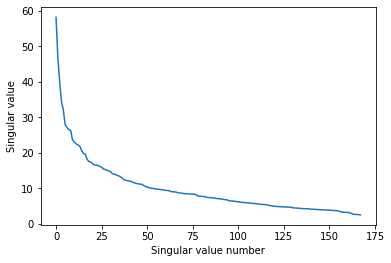

In [49]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [67]:
# these should be the three output matrices -> not sure if rest of code is important (normalization)
songs_compressed, s, tags_compressed = svds(td_matrix, k=10)
tags_compressed = tags_compressed.transpose()

In [57]:
print(tags_compressed.shape)
print(songs_compressed.shape)

(169, 20)
(32014, 20)


In [52]:
# word_to_index = vectorizer.vocabulary_
# index_to_word = {i:t for t,i in word_to_index.items()}
# print(tags_compressed.shape)

(169, 20)


In [53]:
# from sklearn.preprocessing import normalize
# words_compressed_normed = normalize(tags_compressed, axis = 1)

In [54]:
# def closest_words(word_in, words_representation_in, k = 10):
#     if word_in not in word_to_index: return "Not in vocab."
#     sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
#     asort = np.argsort(-sims)[:k+1]
#     return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [ ]:
# td_matrix_np = td_matrix.transpose().toarray()
# td_matrix_np = normalize(td_matrix_np)